# <center> **Coded Apertures: Image Recostruction Test**<center>

- In the basic case of a 1D coded aperture sensor with a 7-elements detector array $D_{i}$, the aperture contains 13 elements (3 + 7+ 3) whose values are 1 if the element corresponds to a hole, and 0 if opaque. The source complex contains seven point sources with intensity $S_{j}$, each one projecting a different portion of the aperture $A$ onto the detector plane.

<center><img src="Images/Imaging_Layout.png" style="width:500px"/></center>

- Depending on the chosen pattern, the aperture will have a certain coding that will be projected onto the detector. In this case, the physical aperture consists of $2L - 1$ elements, so that the detector array will sample all aperture phasings, each one corresponding to an individual point source.

- Each source $S_{j}$ projects only a portion of the aperture onto the detector plane consistent with the source angular displacement relative to the camera’s optical axis or Line of Sight (LOS). The result is a composite of overlapping aperture patterns. The sum total of the recorded data constitutes the "coded" data from which the source distribution must be inferred by image reconstruction.

- To study the "efficiency" of the mask pattern, one can consider the Point Spread Function (PSF) of the sources, which represent the detector's imaging response.

- Different mask patterns can be chosen, but a general evidence is that for a large number of detector elements $L$ the PSF results narrowly peaked with sidelobes that could on average be subtracted.

- In general, performing a cross correlation between the detector image and the aperture allow us to reconstruct the sky image containing the sources $S_{j}$ with their own intensity. Large detector systems have PRFs that are narrowly peaked at zero phase.

- The physical aperture is represented as a matrix with elements 1 or 0 depending on it being respectively transparent (hole) or opaque to the incident radiation. We can write the detector response $D$ as a product between the aperture $A$ and the source distribution $S$.

- In general, we should express the encoding process by adding a background term $B$ that represents the contributions not modulated by the aperture. This would include the detector dark current, cosmic rays, and any other intrinsic detector noise contributions:
$$D = A\star S + B$$

- To reconstruct the sky image $\hat{S}$ (which results in an estimate derived from the data), we can correlate the detector image with a generalized decoding array $G$ acting on the data such that:
$$\hat{S} = G\star D = G\star(A\star S + B) = (G\star A)\star S + G\star B$$

- If one chooses $G$ such that $G\star A = \delta$, the reconstructed image will be artifact free (neglecting the background). So, looking for an aperture and decoding function that are correlating inverses of each other $G = A^{-1}$, the reconstruction will result in:
$$\hat{S} = S + G\star B$$

In [1]:
import collections.abc as c
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hankel
from scipy.signal import correlate

np.set_printoptions(precision=2, suppress=False)

In [10]:
def correlation(A: c.Sequence,
                B: c.Sequence,
                correlation_type: str) -> c.Sequence:
    """
    Performs the correlation between two arrays.
    ----------------------------------------------------------------------------_
    Params:
        A (array):
            First 1D array.
        B (array):
            Second 1D array.
        correlation_type (str):
            'naive', 'hankel' or 'scipy'. If 'hankel', the correlation is
            performed as the matrix product between the Hankel matrix of A and B.

    Returns:
        C (array): 1D correlation array.
    """

    if correlation_type == "naive":
        C_length = len(A) - len(B) + 1
        C = np.zeros(C_length)

        for i in range(C_length):
            C[i] = np.dot(A[i : i + len(B)], B)

    elif correlation_type == "hankel":
        A_matrix = hankel(A[:len(B)], A[-len(B):])
        C = np.matmul(A_matrix, B)
    
    elif correlation_type == "scipy":
        C = correlate(A, B, mode='valid')
    
    else:
        raise ValueError("correlation_type must be 'naive', 'hankel' or 'scipy'.")
    
    return C


def autocorrelation(A: c.Sequence) -> c.Sequence:
    """
    Performs the autocorrelation of the mask pattern.
    -------------------------------------------------
    Params:
        A (array): Mask pattern (1D).
    
    Returns:
        R (array): Autocorrelation array (1D).
    """

    cut = (len(A) - 1)//4
    a = A[cut : -cut]

    R = correlation(A, a, 'scipy')

    return R


def detector_image(mask: c.Sequence,
                   source_distr: c.Sequence,
                   background: bool = True,
                   correlation_type: str = 'scipy') -> c.Sequence:
    """
    Returns the detector image given the mask pattern and the source distribution
    with respective intensities.
    -----------------------------------------------------------------------------
    Params:
        mask (array):
            Mask pattern.
        source_distr (array):
            Distribution of sources with given intensities S_j.
        background (bool):
            If True the detector background is added.
        correlation_type (str, default='numpy'):
            'naive', 'hankel' or 'numpy' (see correlation method above).
    
    Returns:
        D (array): Detector image.
    """

    D = correlation(mask, source_distr, correlation_type)

    if background:
        D = D.astype(np.float64)
        D += np.random.uniform(0.3, 0.6, size=D.shape)
    
    return D


def decoding_function(A: c.Sequence, mask_pattern: str):
    """
    Computes the decoding function from the mask pattern to
    reconstruct the sky image through cross-correlation.
    --------------------------------------------------------------
    Params:
        A (array): Mask pattern.
        mask_pattern (str): 'random' or 'ura'.
    
    Returns:
        G (array): Decoding function (2D if 'random', 1D if 'ura').
    """

    if mask_pattern == 'random':
        cut = (len(A) + 1)//2
        g = np.linalg.inv(hankel(A[:cut], A[-cut:]))
        print(g)
        return g
    
    elif mask_pattern == 'ura':
        cut = (len(A) - 1)//4
        return (2*A - 1)/np.sum(A[cut : -cut])
    
    else:
        raise ValueError("mask_pattern must be 'random' or 'ura'.")


def sky_image_reconstruction(G: c.Sequence,
                             D: c.Sequence,
                             pattern_type: str,
                             correlation_type: str = None) -> c.Sequence:
    """
    Reconstruction of the sky image.
    ---------------------------------------------------------
    Params:
        G (array):
            Mask decoding function (1D if pattern_type is 'ura' else 2D).
        D (array):
            1D detector image.
        pattern_type (str):
            'random' or 'ura'.
        correlation_type (str, default=None):
            'naive', 'hankel' or 'scipy' for URA mask pattern
            (see correlation method above).
    
    Returns:
        S_hat (array): Reconstructed 1D sky image.
    """
    
    if pattern_type == 'random' and len(G.shape) > 1:
        S_hat = np.matmul(G, D)
    
    elif pattern_type == 'ura' and correlation_type is not None:
        S_hat = correlation(G, D, correlation_type)

    return S_hat


def reconstruction_test(G: c.Sequence,
                        D: c.Sequence,
                        S: c.Sequence,
                        pattern_type: str,) -> None:
    """
    Tests the written correlation algorithms for the reconstruction of the sky
    image ('naive' vs 'hankel' vs 'scipy' correlations).
    ------------------------------------------------------------------------------
    Params:
        G (array): Mask decoding function.
        D (array): Detector image.
        S (array): Source distribution.
        pattern_type (str): 'random' or 'ura'.
    """
    
    S_hat_naive = sky_image_reconstruction(G, D, pattern_type, 'naive')
    S_hat_hankel = sky_image_reconstruction(G, D, pattern_type, 'hankel')
    S_hat_scipy = sky_image_reconstruction(G, D, pattern_type, 'scipy')

    print("Sky image reconstruction test with average residues:\n",
          f"naive - hankel: {np.mean(S_hat_naive - S_hat_hankel)}\n",
          f"naive - scipy: {np.mean(S_hat_naive - S_hat_scipy)}\n",
          f"hankel - scipy: {np.mean(S_hat_hankel - S_hat_scipy)}")
    
    print("Average residues between S and S_hat:\n",
          f"naive reconstruction: {np.mean(S - S_hat_naive)}\n",
          f"hankel reconstruction: {np.mean(S - S_hat_hankel)}\n",
          f"scipy reconstruction: {np.mean(S - S_hat_scipy)}")

In [19]:
import matplotlib as mpl
#import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap, Normalize
#from matplotlib.gridspec import GridSpec as gridspec

params= {'font.family': 'sans-serif',
         'font.weight': 'bold',
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}

mpl.rcParams.update(params)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.turbo_r(np.linspace(0,1,5)))


def plot(plot_type: list[str], plot_input: list[c.Sequence], title: list[str],
         xlabel: list[str] = None, ylabel: list[str] = None,
         cbarcmap: list = None, cbarlabel: list[str] = None) -> None:
    """
    Plot(s) of the input array(s) (1D as sequences or 2D as images).
    ------------------------------------------------------------
    Params:
        plot_type (list of str):
            'sequence' for a simple plot of a 1D array, 'image'
            for displaying a 2D array as an image.
        plot_input (list of array):
            Objects to plot (1D or 2D arrays).
        title (list of str):
            Plot titles.
        xlabel (list of str, default=None):
            Labels on the x-axes.
        ylabel (list of str, default=None):
            Labels on the y-axes.
        cbarcmap (list, default=None):
            Colormaps for image plots.
        cbarlabel (list of str, default=None):
            Labels on the colorbars.
    """
    n = len(plot_input)  # Number of plots

    # Handle optional arguments
    xlabel = xlabel or [None]*n
    ylabel = ylabel or [None]*n
    cbarcmap = cbarcmap or [None]*n
    cbarlabel = cbarlabel or [None]*n

    # Create subplots
    fig, axs = plt.subplots(1, n, figsize=(5*n + 2, 7), squeeze=False)

    for i, ax in enumerate(axs.flat):

        # check  plot_type
        if plot_type[i] not in ['sequence', 'image']:
            raise ValueError(f"Invalid plot_type '{plot_type[i]}' for plot {i}. Must be 'sequence' or 'image'.")
        
        if plot_type[i] == 'sequence' and np.ndim(plot_input[i]) != 1:
            raise ValueError(f"Input for 'sequence' plot {i} must be 1D.")
        
        if plot_type[i] == 'image' and np.ndim(plot_input[i]) != 2:
            raise ValueError(f"Input for 'image' plot {i} must be 2D.")

        # plot sequence (1D data)
        if plot_type[i] == 'sequence':
            phase = np.arange(len(plot_input[i]))  # X-axis values
            ax.scatter(phase, plot_input[i], c='OrangeRed', s=70)
            ax.set_xlim(phase[0] - 1, phase[-1] + 1)
            ax.set_ylim(np.min(plot_input[i]) - 1, np.max(plot_input[i]) + 1)

        # plot image (2D data)
        elif plot_type[i] == 'image':
            img = ax.imshow(plot_input[i], cmap=cbarcmap[i], origin='lower')
            cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=0.73, pad=0.04)
            if cbarlabel[i]:
                cbar.set_label(cbarlabel[i], fontsize=12)
            cbar.ax.tick_params(labelsize=10)

        # styling
        ax.set_xlabel(xlabel[i] if xlabel[i] else "")
        ax.set_ylabel(ylabel[i] if ylabel[i] else "")
        ax.set_title(title[i], fontsize=15, pad=10, fontweight="bold")
        _customize_axis(ax)

    plt.tight_layout()
    plt.show()


def _customize_axis(ax):
    """Apply common axis customizations."""

    ax.grid(visible=True, color="lightgray", linestyle="-", linewidth=0.5)
    ax.tick_params(which='both', direction='in', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

### **Random Mask Pattern**

- The peak will on average be of value $L/2$ as a consequence of the aperture being $50\%$ open, while the sidelobes will approximate $L/4$ since, being random, there is a $50\%$ probability that any two given holes overlap.

<center><img src="Images/RandomPattern.png" style="width:700px"/></center>

- Let's build the random mask pattern $A$ and the background $B$, and let's define the sources array.

In [15]:
def random_mask(N: int, hankel_array: bool = False) -> c.Sequence:
    """
    Returns an array of length N with 0s and 1s representing the random
    pattern for the coded mask based on the # of detector elements.
    -------------------------------------------------------------------
    Params:
        N (int):
            Number of detector elements.
        hankel_array (bool, default=False):
            If True the Hankel matrix of the pattern is displayed.
    
    Returns:
        mask_pattern (array): Array with 0s (opaque) and 1s (holes).
    """

    mask_pattern = np.random.randint(0, 2, int(2*N - 1))

    if hankel_array:
            print("Hankel matrix of the mask random-based sequence:\n",
                  hankel(mask_pattern[:N], mask_pattern[-N:]))
    
    # singularity check
    try:
        np.linalg.inv(hankel(mask_pattern[:N], mask_pattern[-N:]))
    except ValueError:
        mask_pattern = random_mask(N, hankel_array)
    
    print(mask_pattern)
    
    return mask_pattern

[1 1 1 0 0 0 1 1 1 0 1 1 0]
[[1 1 1 0 0 0 1]
 [1 1 0 0 0 1 1]
 [1 0 0 0 1 1 1]
 [0 0 0 1 1 1 0]
 [0 0 1 1 1 0 1]
 [0 1 1 1 0 1 1]
 [1 1 1 0 1 1 0]]
[[ 3. -2.  1.  2. -2.  0. -1.]
 [-2.  3. -2. -1.  2. -1.  1.]
 [ 1. -2.  1. -0. -1.  1. -0.]
 [ 2. -1.  0.  2. -1.  0. -1.]
 [-2.  2. -1. -1.  2. -1.  1.]
 [ 0. -1.  1.  0. -1.  1.  0.]
 [-1.  1. -0. -1.  1. -0. -0.]]


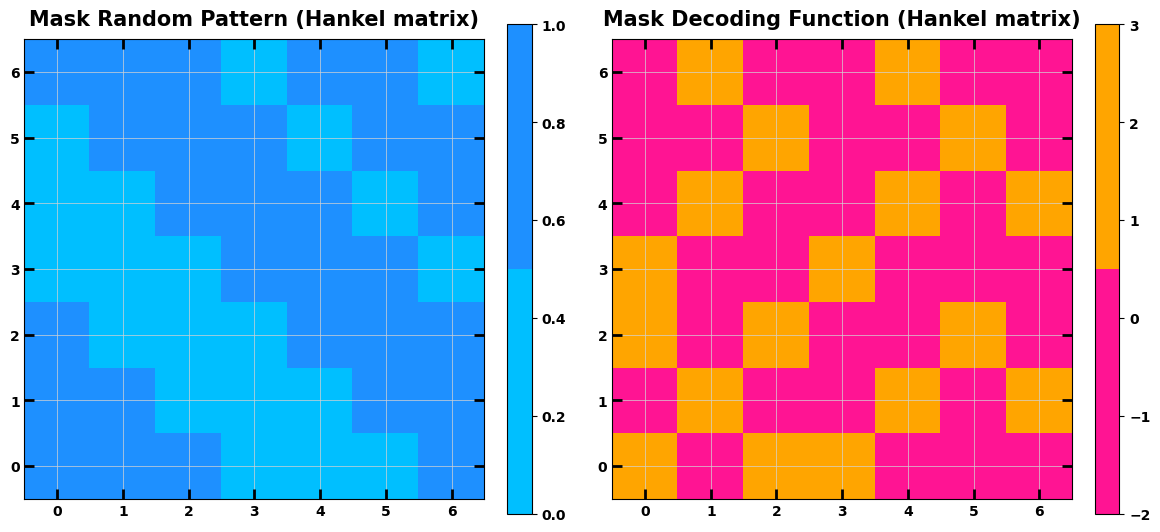

In [ ]:
L = 7

A = random_mask(L)
print(hankel(A[:L], A[-L:]))
G = decoding_function(A, 'random')

plot(['image', 'image'], [hankel(A[:L], A[-L:]), G], ["Mask Random Pattern (Hankel matrix)", "Mask Decoding Function (Hankel matrix)"],
             cbarcmap=[ListedColormap(["DeepSkyBlue", "DodgerBlue"]), ListedColormap(["DeepPink", "Orange"])])


[0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1
 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0
 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1
 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1
 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0
 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0
 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1
 0 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0
 1 0 1]
[[ 0.   -0.13  0.06 ... -0.01  0.07 -0.11]
 [-0.13 -0.02  0.04 ...  0.06 -0.07 -0.06]
 [ 0.06  0.04  0.25 ...  0.07 -0.08 -0.11]
 ...
 [-0.01  0.06  0.07 ...  0.   -0.04  0.01]
 [ 0.07 -0.07 -0.08 ... -0.04  0.08 -0.13]
 [-0.11 -0.06 -0.11 ...  0.01 -0.13  0.08]]
Sky image reconstruction test with average residues:
 naive - hankel: 0.0
 naive - scipy: 0.0
 hankel - scipy: 0.0
Average resid

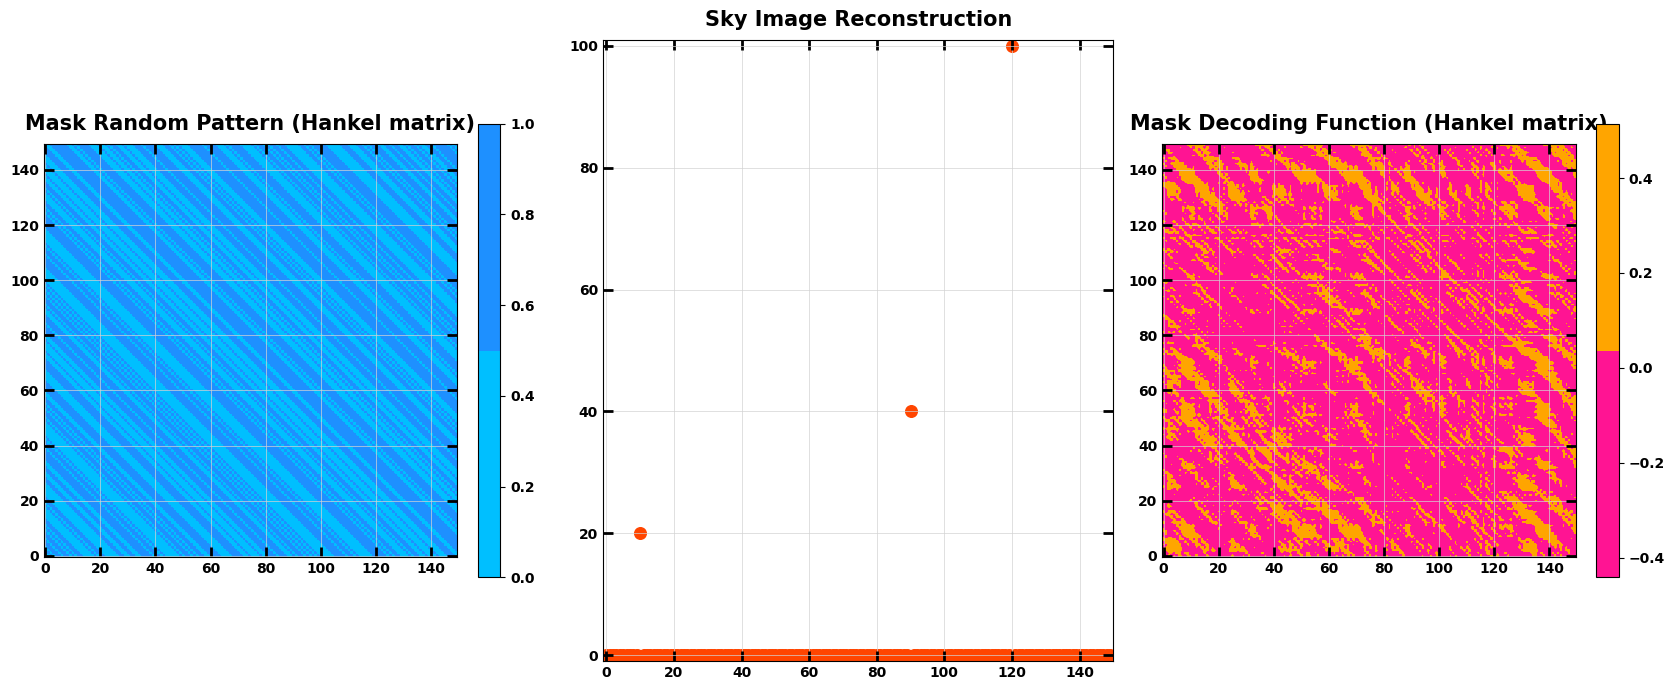

In [ ]:
# sky image reconstruction with random mask pattern
L = 150                                             # detector elements
A = random_mask(L, False)                            # random-based coded mask sequence

S = np.array([0]*L)                                 # sources array with intensities S_j
S[10], S[90], S[120] = 20, 40, 100

D = detector_image(A, S, False, 'scipy')             # detector image with detector background

G = decoding_function(A, 'random')                  # mask decoding function

S_hat = sky_image_reconstruction(G, D, 'random')    # reconstructed sky image

reconstruction_test(G, D, S, 'random')


S, S_hat, S_hat[10], S_hat[90], S_hat[120]

plot(['image', 'sequence', 'image'], [hankel(A[:L], A[-L:]), S_hat, G],
     ["Mask Random Pattern (Hankel matrix)", "Sky Image Reconstruction", "Mask Decoding Function (Hankel matrix)"],
     cbarcmap=[ListedColormap(["DeepSkyBlue", "DodgerBlue"]), None, ListedColormap(["DeepPink", "Orange"])])

### **Uniformly Redundant Array Mask Pattern**

- Uniformly Redundant Arrays (URA) represent a set of binary sequences whose cyclic autocorrelation has constant sidelobe value everywhere, and whose decoding function $G$ is identical to the aperture function $A$ with the exception of the introduction of a normalization factor, and substituting a value of -1 for all zero-valued (opaque) aperture elements.

<center><img src="Images/URA_layout.png" style="width:700px"></center>

In [6]:
def URA_mask(basic_pattern: c.Sequence, hankel_array: bool = False) -> c.Sequence:
    """
    Returns an array with 0s and 1s build from the chosen basic pattern
    representing the whole coded sequence for the mask.
    -------------------------------------------------------------------
    Params:
        basic_pattern (array):
            Mask basic pattern.
        hankel_array (bool, default=False):
            If True the Hankel matrix of the URA pattern is displayed.
    
    Returns:
        mask_pattern (array): Array with 0s (opaque) and 1s (holes).
    """

    cut = (len(basic_pattern) - 1)//2

    prefix = basic_pattern[-cut:]
    suffix = basic_pattern[:cut]

    mask_pattern = np.concatenate((prefix, basic_pattern, suffix))

    if hankel_array:
        print("Hankel matrix of the mask URA-based sequence:\n",
              hankel(mask_pattern[:len(basic_pattern)], mask_pattern[-len(basic_pattern):]))
    
    return mask_pattern

Hankel matrix of the mask URA-based sequence:
 [[1 0 0 1 1 1 0]
 [0 0 1 1 1 0 1]
 [0 1 1 1 0 1 0]
 [1 1 1 0 1 0 0]
 [1 1 0 1 0 0 1]
 [1 0 1 0 0 1 1]
 [0 1 0 0 1 1 1]]
Sky image reconstruction test with average residues:
 naive - hankel: 0.0
 naive - scipy: 1.0150610510858574e-15
 hankel - scipy: 1.0150610510858574e-15
Average residues between S and S_hat:
 naive reconstruction: -0.11858256611624032
 hankel reconstruction: -0.11858256611624032
 scipy reconstruction: -0.11858256611623931


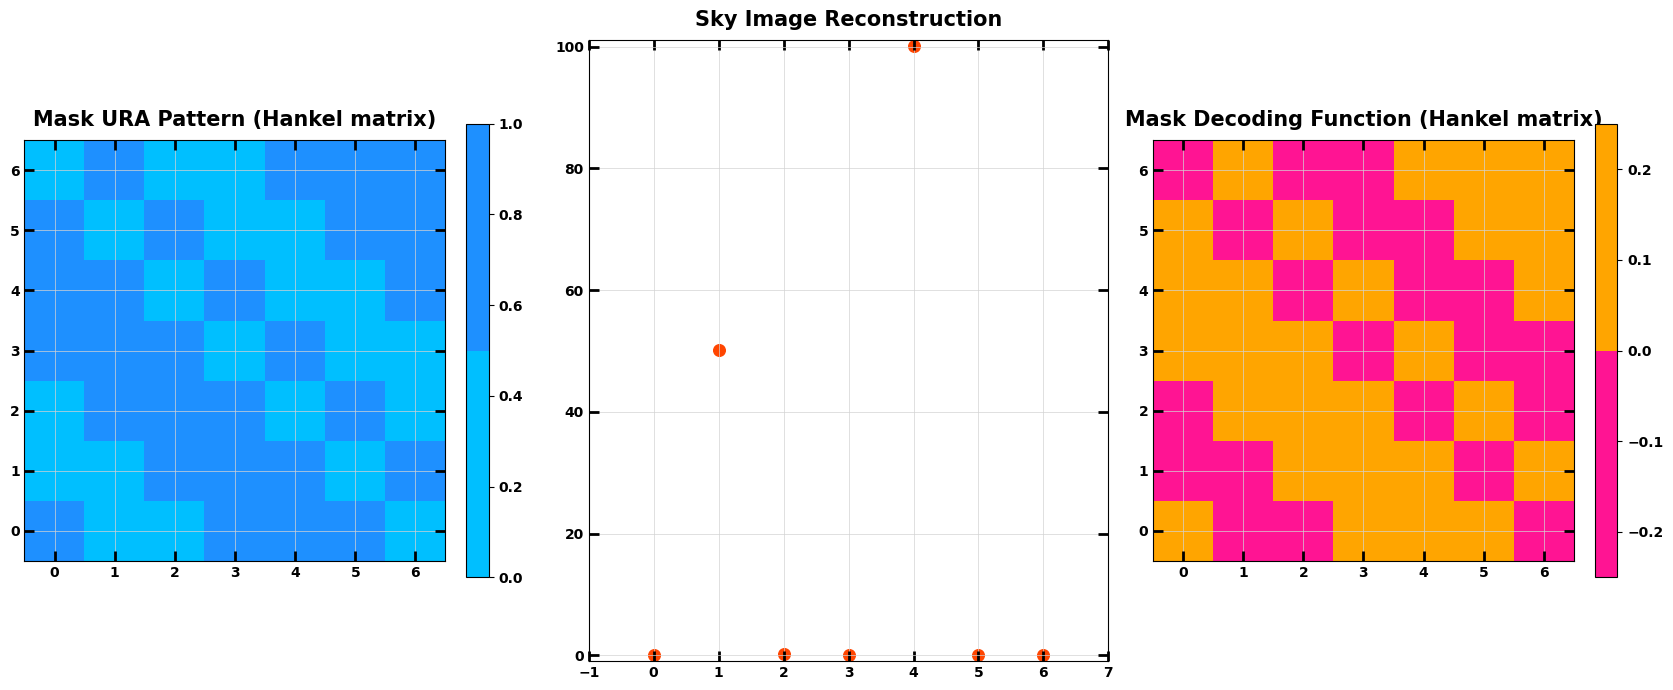

In [24]:
# sky image reconstruction with URA mask pattern
basic_pattern = np.array([1, 1, 1, 0, 1, 0, 0])   # URA basic pattern
A = URA_mask(basic_pattern, True)                 # URA-based coded mask sequence

S = np.array([0, 50, 0, 0, 100, 0, 0])            # sources array with intensities S_j

D = detector_image(A, S, True, 'scipy')           # detector image with detector background

G = decoding_function(A, 'ura')                   # mask decoding function

S_hat = sky_image_reconstruction(G, D, 'ura', 'scipy')  # reconstructed sky image


reconstruction_test(G, D, S, 'ura')                     # reconstruction algorithms test

plot(['image', 'sequence', 'image'], [hankel(A[:len(basic_pattern)], A[-len(basic_pattern):]), S_hat, hankel(G[:len(basic_pattern)], G[-len(basic_pattern):])],
     ["Mask URA Pattern (Hankel matrix)", "Sky Image Reconstruction", "Mask Decoding Function (Hankel matrix)"],
     cbarcmap=[ListedColormap(["DeepSkyBlue", "DodgerBlue"]), None, ListedColormap(["DeepPink", "Orange"])])

To do:

1. snellire codici per notebook
2. aggiustare pattern random (usare direttamente A come sequenza, togliere G come inversa -> fare come con URA che sono tutte sequenze)
3. scrivere più funzioni invece di mettere if else con strings

4. SNR
5. 2D all-in


NOTA: mandare link della repo a Peppe<br>
NOTA: in the "test" function, we want the output to be a bool (e.g. np.all(S_hat - S) = is_close_to_zero())

## **Test with 2D detectors and sky**

### **References**<br>
[1] Gottesman, S. R., "Coded apertures: past, present, and future application and design", 2007